In [1]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from census import Census
import gmaps
from pprint import pprint
import zipcodes

# Census & gmaps API Keys
from config import (census_api_key, gkey)
c = Census(census_api_key, year=2017)

# Configure gmaps
gmaps.configure(api_key=gkey)

In [2]:
# Run Census Search to retrieve data on all states
# Note the addition of "B23025_005E" for unemployment count
census_housing = c.acs5.get(("NAME", "B01003_001E", "B01002_001E", "B19013_001E", "B25058_001E", "B25064_001E", "B25077_001E", "B25088_002E"), {'for': 'state:*'}) #'for': 'zip code tabulation area:*' ) 

# Convert to DataFrame
census_housing = pd.DataFrame(census_housing)

# Column Reordering
census_housing = census_housing.rename(columns={
                                      "B01003_001E": "Population",
                                      "B01002_001E": "Median Age",
                                      "B19013_001E": "Household Income",
                                      "B25058_001E": "Median Contract Rent",
                                      "B25064_001E": "Median Gross Rent",
                                      "B25077_001E": "Median Home Value",
                                      "B25088_002E": "Median Monthly Owner Costs",
                                      "NAME": "Name","state": "State"})  #"zip code tabulation area": "Zipcode"


# Final DataFrame
census_housing = census_housing[["State", "Name", "Population", "Median Age", "Household Income", "Median Contract Rent", "Median Gross Rent", "Median Home Value",
                       "Median Monthly Owner Costs"]]

sorted_census_housing = census_housing.sort_values("Median Contract Rent", ascending=False)
sorted_census_housing.head()

,State,Name,Population,Median Age,Household Income,Median Contract Rent,Median Gross Rent,Median Home Value,Median Monthly Owner Costs
12,15,Hawaii,1421658.0,38.8,74923.0,1348.0,1507.0,563900.0,2303.0
8,11,District of Columbia,672391.0,33.9,77649.0,1330.0,1424.0,537400.0,2375.0
5,06,California,38982847.0,36.1,67169.0,1227.0,1358.0,443400.0,2206.0
22,24,Maryland,5996079.0,38.5,78916.0,1153.0,1311.0,296500.0,1954.0
31,34,New Jersey,8960161.0,39.6,76475.0,1111.0,1249.0,321100.0,2398.0


In [3]:
# Read in the csv containing state happiness rates
happiness = pd.read_csv("./happiness.csv")
happiness.head()

,Name,Happiness Rating
0,South Dakota,64.1
1,Vermont,64.1
2,Hawaii,63.4
3,Minnesota,63.1
4,North Dakota,63.1


In [4]:
# Merge happiness and housing data
census_housing_hapiness = pd.merge(census_housing, happiness, on="Name")
# sorted_df = merge_table.sort_values("rating", ascending=False)
census_housing_hapiness.head()

,State,Name,Population,Median Age,Household Income,Median Contract Rent,Median Gross Rent,Median Home Value,Median Monthly Owner Costs,Happiness Rating
0,01,Alabama,4850771.0,38.7,46472.0,544.0,747.0,132100.0,1149.0,60.8
1,02,Alaska,738565.0,33.9,76114.0,1091.0,1200.0,261900.0,1862.0,61.6
2,04,Arizona,6809946.0,37.2,53510.0,810.0,972.0,193200.0,1354.0,62.2
3,05,Arkansas,2977944.0,37.9,43813.0,527.0,709.0,118500.0,1039.0,59.4
4,06,California,38982847.0,36.1,67169.0,1227.0,1358.0,443400.0,2206.0,62.3


In [5]:
#See if there is any correlation of happiness rating with housing
census_housing_hapiness.corr(method='pearson', min_periods=1)

,Population,Median Age,Household Income,Median Contract Rent,Median Gross Rent,Median Home Value,Median Monthly Owner Costs,Happiness Rating
Population,1.000000,-0.105097,0.082771,0.322800,0.346376,0.214330,0.288645,0.045735
Median Age,-0.105097,1.000000,-0.052873,0.002826,0.012225,0.021384,0.095047,-0.073792
Household Income,0.082771,-0.052873,1.000000,0.858988,0.827843,0.775374,0.889327,0.471646
Median Contract Rent,0.322800,0.002826,0.858988,1.000000,0.989244,0.920706,0.933929,0.409873
Median Gross Rent,0.346376,0.012225,0.827843,0.989244,1.000000,0.906682,0.917767,0.335671
Median Home Value,0.214330,0.021384,0.775374,0.920706,0.906682,1.000000,0.891076,0.432719
Median Monthly Owner Costs,0.288645,0.095047,0.889327,0.933929,0.917767,0.891076,1.000000,0.387436
Happiness Rating,0.045735,-0.073792,0.471646,0.409873,0.335671,0.432719,0.387436,1.000000


In [6]:
# Pull commuting data (counts and minutes) from Census API by zip
commute_byst= c.acs5.get(("B08136_003E", "B08136_004E", "B08136_007E","B08136_011E", "B08136_012E","B08301_001E",
                           "B08301_003E","B08301_004E", "B08301_010E","B08301_019E","B08101_041E","NAME"), {'for': 'state:*'})

# Convert to DataFrame
commute_byst_pd = pd.DataFrame(commute_byst)
                                
commute_byst_pd = commute_byst_pd.rename(columns={"B08136_003E":"ct_solo_auto", "B08136_004E":"ct_carpool", "B08136_007E":"ct_pub_trans",
                                                    "B08136_011E":"ct_walked", "B08136_012E":"ct_other","B08301_001E":"t_total","B08301_003E":"t_solo_auto","B08301_004E":"t_carpool",
                                                    "B08301_010E":"t_public_transport","B08301_019E":"t_walked","B08101_041E":"t_other","NAME": "Name"})
commute_byst_pd.head()

,t_other,ct_solo_auto,ct_carpool,ct_pub_trans,ct_walked,ct_other,t_total,t_solo_auto,t_carpool,t_public_transport,t_walked,Name,state
0,19331.0,24161705.0,2761480.0,1057085.0,393255.0,502590.0,1009568.0,828868.0,85272.0,21692.0,32317.0,Puerto Rico,72
1,20531.0,42207585.0,4900280.0,324595.0,241960.0,639890.0,2030100.0,1743217.0,173758.0,7433.0,22659.0,Alabama,01
2,18829.0,4423270.0,871085.0,219085.0,242730.0,733835.0,360701.0,247111.0,44744.0,5453.0,28714.0,Alaska,02
3,76546.0,54323095.0,8771110.0,2832275.0,694310.0,2286730.0,2916850.0,2234990.0,317969.0,58267.0,57699.0,Arizona,04
4,15329.0,22402830.0,3183235.0,159640.0,220485.0,396940.0,1258851.0,1044010.0,132343.0,4663.0,21933.0,Arkansas,05


In [7]:
# Merge happiness and comute data
commute_byst_pd_happiness = pd.merge(commute_byst_pd, happiness, on="Name")
# sorted_df = merge_table.sort_values("rating", ascending=False)
commute_byst_pd_happiness.head()

,t_other,ct_solo_auto,ct_carpool,ct_pub_trans,ct_walked,ct_other,t_total,t_solo_auto,t_carpool,t_public_transport,t_walked,Name,state,Happiness Rating
0,20531.0,42207585.0,4900280.0,324595.0,241960.0,639890.0,2030100.0,1743217.0,173758.0,7433.0,22659.0,Alabama,01,60.8
1,18829.0,4423270.0,871085.0,219085.0,242730.0,733835.0,360701.0,247111.0,44744.0,5453.0,28714.0,Alaska,02,61.6
2,76546.0,54323095.0,8771110.0,2832275.0,694310.0,2286730.0,2916850.0,2234990.0,317969.0,58267.0,57699.0,Arizona,04,62.2
3,15329.0,22402830.0,3183235.0,159640.0,220485.0,396940.0,1258851.0,1044010.0,132343.0,4663.0,21933.0,Arkansas,05,59.4
4,450486.0,355836415.0,58162215.0,45997080.0,6155215.0,12811450.0,17589758.0,12950487.0,1830958.0,909679.0,470101.0,California,06,62.3


In [8]:
#See if there is any correlation of happiness rating with commute time
commute_byst_pd_happiness.corr(method='pearson', min_periods=1)

,t_other,ct_solo_auto,ct_carpool,ct_pub_trans,ct_walked,ct_other,t_total,t_solo_auto,t_carpool,t_public_transport,t_walked,Happiness Rating
t_other,1.000000,0.953343,0.977144,0.554829,0.792837,0.995570,0.961646,0.942528,0.967137,0.561172,0.820036,0.119433
ct_solo_auto,0.953343,1.000000,0.985826,0.465339,0.721845,0.961850,0.991108,0.997302,0.992143,0.470418,0.762215,0.062419
ct_carpool,0.977144,0.985826,1.000000,0.470125,0.729847,0.981372,0.978981,0.978551,0.996300,0.474734,0.765405,0.089861
ct_pub_trans,0.554829,0.465339,0.470125,1.000000,0.923984,0.524534,0.566059,0.448702,0.451347,0.999332,0.896631,0.062512
ct_walked,0.792837,0.721845,0.729847,0.923984,1.000000,0.765695,0.799211,0.710165,0.715350,0.929616,0.996125,0.091354
ct_other,0.995570,0.961850,0.981372,0.524534,0.765695,1.000000,0.964802,0.951649,0.974388,0.529333,0.792092,0.129965
t_total,0.961646,0.991108,0.978981,0.566059,0.799211,0.964802,1.000000,0.990325,0.985257,0.573324,0.835666,0.059241
t_solo_auto,0.942528,0.997302,0.978551,0.448702,0.710165,0.951649,0.990325,1.000000,0.990160,0.457293,0.755610,0.043110
t_carpool,0.967137,0.992143,0.996300,0.451347,0.715350,0.974388,0.985257,0.990160,1.000000,0.459162,0.756553,0.073979
t_public_transport,0.561172,0.470418,0.474734,0.999332,0.929616,0.529333,0.573324,0.457293,0.459162,1.000000,0.902757,0.060696


In [9]:
# Run Census Search to retrieve data on all states
census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E", "B01002_001E",
                          "B19301_001E",
                          "B17001_002E",
                          "B17001_003E",
                          "B17001_017E",
                          "B17001A_002E",
                          "B17001B_002E",
                          "B17001C_002E",
                          "B17001D_002E",
                          "B17001E_002E",
                          "B17001G_002E",
                          "B17012_002E",
                          "B17012_003E",
                          "B17012_009E",
                          "B17012_014E",
                          "B15003_022E",
                          "B23025_005E"), {'for': 'state:*'} ) #{'for': 'state:*'}
# Convert to DataFrame
income_pd = pd.DataFrame(census_data)

# Column Reordering
income_pd = income_pd.rename(columns={"B01003_001E": "Population",
                                      "B01002_001E": "Median Age",
                                      "B19013_001E": "Median Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "B17001_002E": "below poverty level",
                                      "B17001_003E": "male below poverty level",
                                      "B17001_017E": "female below poverty level",
                                      "B17001A_002E": "whites below poverty level",
                                      "B17001B_002E": "blacks below poverty level",
                                      "B17001C_002E": "American Indians below poverty level",
                                      "B17001D_002E": "Asians below poverty level",
                                      "B17001E_002E": "Hispanic below poverty level",
                                      "B17001G_002E":"Two or more races below poverty level",
                                      "B17012_002E": "Families below poverty level",
                                      "B17012_003E": "Married families below poverty level",
                                      "B17012_009E":"Male families below poverty level",
                                      "B17012_014E":"Female families below poverty level",
                                      "B23025_005E": "Unemployment Count",
                                      "NAME": "Name", "state": "State"}) #"state": "State"


# Add in Employment Rate (Employment Count / Population)
income_pd["Unemployment Rate"] = 100 * \
    income_pd["Unemployment Count"].astype(
        int) / income_pd["Population"].astype(int)

# Final DataFrame
income_pd = income_pd[["State", "Name", "Population", "Median Age", "Median Household Income",
                       "Per Capita Income", "below poverty level","male below poverty level","female below poverty level", 
                       "whites below poverty level","blacks below poverty level","American Indians below poverty level",
                       "Asians below poverty level","Hispanic below poverty level","Two or more races below poverty level","Families below poverty level","Married families below poverty level",
                       "Female families below poverty level",
                       "Male families below poverty level",
                       "Unemployment Rate"]]

income_pd.head()

,State,Name,Population,Median Age,Median Household Income,Per Capita Income,below poverty level,male below poverty level,female below poverty level,whites below poverty level,blacks below poverty level,American Indians below poverty level,Asians below poverty level,Hispanic below poverty level,Two or more races below poverty level,Families below poverty level,Married families below poverty level,Female families below poverty level,Male families below poverty level,Unemployment Rate
0,72,Puerto Rico,3468963.0,40.1,19775.0,12081.0,1543220.0,703161.0,840059.0,1026976.0,154131.0,5302.0,4113.0,75.0,91136.0,350299.0,140149.0,171297.0,38853.0,6.359163
1,01,Alabama,4850771.0,38.7,46472.0,25746.0,849699.0,367621.0,482078.0,432404.0,360407.0,4209.0,8597.0,334.0,20259.0,167495.0,52345.0,100023.0,15127.0,3.409582
2,02,Alaska,738565.0,33.9,76114.0,35065.0,73380.0,35420.0,37960.0,31659.0,3387.0,24116.0,4673.0,1312.0,6826.0,11622.0,3891.0,5631.0,2100.0,4.000731
3,04,Arizona,6809946.0,37.2,53510.0,27964.0,1128046.0,522398.0,605648.0,764158.0,62682.0,104167.0,27329.0,2646.0,42465.0,199167.0,84533.0,90233.0,24401.0,3.317368
4,05,Arkansas,2977944.0,37.9,43813.0,24426.0,524211.0,235444.0,288767.0,332449.0,139406.0,4447.0,5909.0,2031.0,17116.0,100338.0,36871.0,52923.0,10544.0,2.858617


In [10]:
# Merge happiness and poverty data
census_poverty_hapiness = pd.merge(income_pd, happiness, on="Name")
# sorted_df = merge_table.sort_values("rating", ascending=False)
census_poverty_hapiness.head()

,State,Name,Population,Median Age,Median Household Income,Per Capita Income,below poverty level,male below poverty level,female below poverty level,whites below poverty level,...,American Indians below poverty level,Asians below poverty level,Hispanic below poverty level,Two or more races below poverty level,Families below poverty level,Married families below poverty level,Female families below poverty level,Male families below poverty level,Unemployment Rate,Happiness Rating
0,01,Alabama,4850771.0,38.7,46472.0,25746.0,849699.0,367621.0,482078.0,432404.0,...,4209.0,8597.0,334.0,20259.0,167495.0,52345.0,100023.0,15127.0,3.409582,60.8
1,02,Alaska,738565.0,33.9,76114.0,35065.0,73380.0,35420.0,37960.0,31659.0,...,24116.0,4673.0,1312.0,6826.0,11622.0,3891.0,5631.0,2100.0,4.000731,61.6
2,04,Arizona,6809946.0,37.2,53510.0,27964.0,1128046.0,522398.0,605648.0,764158.0,...,104167.0,27329.0,2646.0,42465.0,199167.0,84533.0,90233.0,24401.0,3.317368,62.2
3,05,Arkansas,2977944.0,37.9,43813.0,24426.0,524211.0,235444.0,288767.0,332449.0,...,4447.0,5909.0,2031.0,17116.0,100338.0,36871.0,52923.0,10544.0,2.858617,59.4
4,06,California,38982847.0,36.1,67169.0,33128.0,5773408.0,2644246.0,3129162.0,3183011.0,...,62078.0,607792.0,21470.0,254976.0,986374.0,424040.0,446114.0,116220.0,3.825134,62.3


In [11]:
#See if there is any correlation of happiness rating with commute time
census_poverty_hapiness.corr(method='pearson', min_periods=1)

,Population,Median Age,Median Household Income,Per Capita Income,below poverty level,male below poverty level,female below poverty level,whites below poverty level,blacks below poverty level,American Indians below poverty level,Asians below poverty level,Hispanic below poverty level,Two or more races below poverty level,Families below poverty level,Married families below poverty level,Female families below poverty level,Male families below poverty level,Unemployment Rate,Happiness Rating
Population,1.000000,-0.105097,0.082771,0.109213,0.991432,0.991318,0.991171,0.971832,0.751522,0.282020,0.855417,0.341843,0.950055,0.985915,0.981725,0.974459,0.986268,0.348682,0.045735
Median Age,-0.105097,1.000000,-0.052873,0.185726,-0.121760,-0.123207,-0.120525,-0.114344,-0.028707,-0.290199,-0.126173,-0.117470,-0.105017,-0.125406,-0.146339,-0.111221,-0.102311,0.151763,-0.073792
Median Household Income,0.082771,-0.052873,1.000000,0.914147,-0.015234,-0.012560,-0.017431,-0.044418,-0.183171,-0.107890,0.215047,0.297524,0.090439,-0.039458,-0.014980,-0.060933,-0.031021,-0.012277,0.471646
Per Capita Income,0.109213,0.185726,0.914147,1.000000,0.007538,0.007663,0.007433,-0.024800,-0.104307,-0.153124,0.203079,0.082151,0.095547,-0.014296,-0.009200,-0.019730,-0.007677,0.041162,0.412720
below poverty level,0.991432,-0.121760,-0.015234,0.007538,1.000000,0.999762,0.999839,0.982189,0.774202,0.310843,0.839142,0.336498,0.942272,0.998137,0.994349,0.986932,0.994945,0.360075,0.005884
male below poverty level,0.991318,-0.123207,-0.012560,0.007663,0.999762,1.000000,0.999209,0.982679,0.763178,0.319382,0.845030,0.345273,0.945535,0.996923,0.995292,0.983511,0.995768,0.356490,0.012017
female below poverty level,0.991171,-0.120525,-0.017431,0.007433,0.999839,0.999209,1.000000,0.981434,0.783006,0.303698,0.833993,0.329150,0.939247,0.998780,0.993216,0.989397,0.993911,0.362900,0.000831
whites below poverty level,0.971832,-0.114344,-0.044418,-0.024800,0.982189,0.982679,0.981434,1.000000,0.721537,0.305827,0.768036,0.307576,0.907012,0.983461,0.985350,0.969282,0.973364,0.300804,0.021132
blacks below poverty level,0.751522,-0.028707,-0.183171,-0.104307,0.774202,0.763178,0.783006,0.721537,1.000000,0.006849,0.450648,0.036213,0.630098,0.793864,0.728815,0.843767,0.756666,0.468973,-0.187737
American Indians below poverty level,0.282020,-0.290199,-0.107890,-0.153124,0.310843,0.319382,0.303698,0.305827,0.006849,1.000000,0.335350,0.169898,0.380198,0.297738,0.336801,0.252372,0.337299,0.087031,0.143670


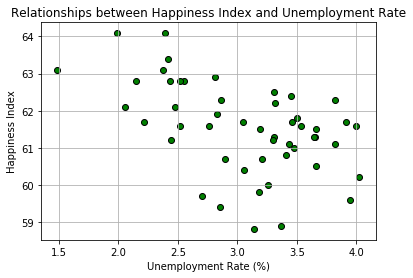

In [13]:
plt.scatter(census_poverty_hapiness["Unemployment Rate"], census_poverty_hapiness["Happiness Rating"],color="green", marker="o", edgecolors="black")
plt.title("Relationships between Happiness Index and Unemployment Rate")
plt.xlabel("Unemployment Rate (%)")
plt.ylabel("Happiness Index")
#Create the grid
plt.grid(True)
# Save the Figure
plt.savefig("images/RelationshipsHappinessUnemployment.png")

In [54]:
#states with lowest unemployment rate
sorted_census_poverty_hapiness = census_poverty_hapiness.sort_values("Unemployment Rate", ascending=True)
sorted_census_poverty_hapiness.head()

,State,Name,Population,Median Age,Median Household Income,Per Capita Income,below poverty level,male below poverty level,female below poverty level,whites below poverty level,...,American Indians below poverty level,Asians below poverty level,Hispanic below poverty level,Two or more races below poverty level,Families below poverty level,Married families below poverty level,Female families below poverty level,Male families below poverty level,Unemployment Rate,Happiness Rating
33,38,North Dakota,745475.0,35.1,61285.0,34256.0,79374.0,36668.0,42706.0,53746.0,...,14234.0,1996.0,93.0,3687.0,12688.0,4312.0,6494.0,1882.0,1.486971,63.1
40,46,South Dakota,855444.0,36.8,54126.0,28761.0,114885.0,52200.0,62685.0,67289.0,...,34402.0,2637.0,92.0,5639.0,19344.0,6597.0,10387.0,2360.0,1.989376,64.1
26,31,Nebraska,1893921.0,36.3,56675.0,29866.0,220330.0,96880.0,123450.0,166699.0,...,4985.0,7868.0,269.0,9011.0,38789.0,14203.0,20676.0,3910.0,2.052937,62.1
43,49,Utah,2993941.0,30.5,65325.0,26907.0,324856.0,150747.0,174109.0,248083.0,...,9261.0,9914.0,4035.0,11440.0,55589.0,28214.0,22376.0,4999.0,2.148139,62.8
14,19,Iowa,3118102.0,38.1,56570.0,30063.0,361343.0,161197.0,200146.0,288702.0,...,2899.0,12637.0,770.0,13878.0,60823.0,21460.0,32417.0,6946.0,2.213462,61.7


In [14]:
# Run Census Search to retrieve data on all states
# Note the addition of "B23025_005E" for unemployment count
census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E", "B01002_001E",
                          "B19301_001E",
                          "B15003_002E",
                          "B15003_018E",
                          "B15003_017E",
                          "B15003_021E",
                          "B15003_022E",
                          "B15003_023E",
                          "B15003_024E",
                          "B15003_025E",                          
                          "B23025_005E"), {'for': 'state:*'} )
# Convert to DataFrame
education_pd = pd.DataFrame(census_data)

# Column Reordering
education_pd = education_pd.rename(columns={"B01003_001E": "Population",
                                      "B01002_001E": "Median Age",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "B15003_002E": "Education None",
                                      "B15003_018E": "Education GED",
                                      "B15003_017E": "Education High School",
                                      "B15003_021E": "Education Associates",
                                      "B15003_022E": "Education Bachelors",
                                      "B15003_023E": "Education Masters",
                                      "B15003_024E": "Education Professional",                                    
                                      "B15003_025E": "Education Doctorate",
                                      "B23025_005E": "Unemployment Count",
                                      "NAME": "Name", "state": "State"})

# Add in Poverty Rate (Poverty Count / Population)
# census_pd["Poverty Rate"] = 100 * \
#     census_pd["Poverty Count"].astype(int) / census_pd["Population"].astype(int)

# Add in Employment Rate (Employment Count / Population)
education_pd["Unemployment Rate"] = 100 * \
    education_pd["Unemployment Count"].astype(
        int) / education_pd["Population"].astype(int)
# Percentages of people by educational attainment
education_pd["Education None_percent"] = (education_pd["Education None"].astype(int) / education_pd["Population"].astype(int)) * 100
education_pd["Education GED_percent"] = (education_pd["Education GED"].astype(int) / education_pd["Population"].astype(int)) * 100
education_pd["Education High School_percent"] = (education_pd["Education High School"].astype(int) / education_pd["Population"].astype(int)) * 100
education_pd["Education Associates_percent"] = (education_pd["Education Associates"].astype(int) / education_pd["Population"].astype(int)) * 100
education_pd["Education Bachelors_percent"] = (education_pd["Education Bachelors"].astype(int) / education_pd["Population"].astype(int)) * 100
education_pd["Education Masters_percent"] = (education_pd["Education Masters"].astype(int) / education_pd["Population"].astype(int)) * 100
education_pd["Education Professional_percent"] = (education_pd["Education Professional"].astype(int) / education_pd["Population"].astype(int)) * 100
education_pd["Education Doctorate_percent"] = (education_pd["Education Doctorate"].astype(int) / education_pd["Population"].astype(int)) * 100

# Final DataFrame
education_pd = education_pd[["State", "Name","Population", "Median Age", "Household Income",
                       "Per Capita Income", "Education None", "Education Bachelors", \
                             "Unemployment Rate", "Education None_percent", "Education GED_percent", \
                             "Education High School_percent", "Education Associates_percent", \
                             "Education Bachelors_percent", "Education Masters_percent", \
                             "Education Professional_percent", "Education Doctorate_percent" ]]

education_pd.head()

,State,Name,Population,Median Age,Household Income,Per Capita Income,Education None,Education Bachelors,Unemployment Rate,Education None_percent,Education GED_percent,Education High School_percent,Education Associates_percent,Education Bachelors_percent,Education Masters_percent,Education Professional_percent,Education Doctorate_percent
0,72,Puerto Rico,3468963.0,40.1,19775.0,12081.0,62694.0,426310.0,6.359163,1.807284,1.802095,17.205459,6.743975,12.289263,3.331399,0.842932,0.710673
1,01,Alabama,4850771.0,38.7,46472.0,25746.0,41118.0,503930.0,3.409582,0.847659,3.722233,17.151789,5.509330,10.388658,4.452921,1.019467,0.704939
2,02,Alaska,738565.0,33.9,76114.0,35065.0,3451.0,88308.0,4.000731,0.467257,3.402680,14.374090,5.444341,11.956700,4.843176,1.202061,0.658710
3,04,Arizona,6809946.0,37.2,53510.0,27964.0,65604.0,802435.0,3.317368,0.963356,2.668053,13.357610,5.682527,11.783280,5.100026,1.170185,0.810932
4,05,Arkansas,2977944.0,37.9,43813.0,24426.0,23003.0,280677.0,2.858617,0.772446,4.155988,18.728458,4.440010,9.425194,3.730560,0.878324,0.654848


In [15]:
# Merge happiness and poverty data
census_education_hapiness = pd.merge(education_pd, happiness, on="Name")
# sorted_df = merge_table.sort_values("rating", ascending=False)
census_education_hapiness.head()

,State,Name,Population,Median Age,Household Income,Per Capita Income,Education None,Education Bachelors,Unemployment Rate,Education None_percent,Education GED_percent,Education High School_percent,Education Associates_percent,Education Bachelors_percent,Education Masters_percent,Education Professional_percent,Education Doctorate_percent,Happiness Rating
0,01,Alabama,4850771.0,38.7,46472.0,25746.0,41118.0,503930.0,3.409582,0.847659,3.722233,17.151789,5.509330,10.388658,4.452921,1.019467,0.704939,60.8
1,02,Alaska,738565.0,33.9,76114.0,35065.0,3451.0,88308.0,4.000731,0.467257,3.402680,14.374090,5.444341,11.956700,4.843176,1.202061,0.658710,61.6
2,04,Arizona,6809946.0,37.2,53510.0,27964.0,65604.0,802435.0,3.317368,0.963356,2.668053,13.357610,5.682527,11.783280,5.100026,1.170185,0.810932,62.2
3,05,Arkansas,2977944.0,37.9,43813.0,24426.0,23003.0,280677.0,2.858617,0.772446,4.155988,18.728458,4.440010,9.425194,3.730560,0.878324,0.654848,59.4
4,06,California,38982847.0,36.1,67169.0,33128.0,691906.0,5291984.0,3.825134,1.774899,1.520369,12.192180,5.186753,13.575160,5.477732,1.581126,1.051752,62.3


In [16]:
#See if there is any correlation of happiness rating with edication
census_education_hapiness.corr(method='pearson', min_periods=1)

,Population,Median Age,Household Income,Per Capita Income,Education None,Education Bachelors,Unemployment Rate,Education None_percent,Education GED_percent,Education High School_percent,Education Associates_percent,Education Bachelors_percent,Education Masters_percent,Education Professional_percent,Education Doctorate_percent,Happiness Rating
Population,1.000000,-0.105097,0.082771,0.109213,0.955777,0.993240,0.348682,0.763669,-0.270761,-0.227417,-0.241875,0.079983,0.134679,0.238506,0.045108,0.045735
Median Age,-0.105097,1.000000,-0.052873,0.185726,-0.139845,-0.090786,0.151763,-0.116113,0.164133,0.619451,0.129130,0.196222,0.380073,0.345933,0.294092,-0.073792
Household Income,0.082771,-0.052873,1.000000,0.914147,0.121927,0.164115,-0.012277,0.072705,-0.716482,-0.366238,0.076990,0.766783,0.676754,0.710643,0.627467,0.471646
Per Capita Income,0.109213,0.185726,0.914147,1.000000,0.117681,0.195517,0.041162,0.087146,-0.628709,-0.246437,0.096694,0.830885,0.811411,0.815716,0.699901,0.412720
Education None,0.955777,-0.139845,0.121927,0.117681,1.000000,0.958623,0.304173,0.783857,-0.284518,-0.287030,-0.205567,0.081428,0.100003,0.233772,0.065916,0.095241
Education Bachelors,0.993240,-0.090786,0.164115,0.195517,0.958623,1.000000,0.339817,0.767233,-0.335512,-0.265482,-0.219882,0.171655,0.208382,0.315973,0.117809,0.096768
Unemployment Rate,0.348682,0.151763,-0.012277,0.041162,0.304173,0.339817,1.000000,0.579227,0.143595,-0.002223,-0.549547,-0.218880,0.245237,0.262096,0.111216,-0.496024
Education None_percent,0.763669,-0.116113,0.072705,0.087146,0.783857,0.767233,0.579227,1.000000,-0.219743,-0.304935,-0.399819,-0.018160,0.187557,0.324056,0.186622,-0.149958
Education GED_percent,-0.270761,0.164133,-0.716482,-0.628709,-0.284518,-0.335512,0.143595,-0.219743,1.000000,0.399334,-0.198339,-0.710407,-0.464144,-0.539362,-0.502898,-0.572916
Education High School_percent,-0.227417,0.619451,-0.366238,-0.246437,-0.287030,-0.265482,-0.002223,-0.304935,0.399334,1.000000,-0.020730,-0.363820,-0.206233,-0.210869,-0.237737,-0.443934


Text(0, 0.5, 'Happiness Index')

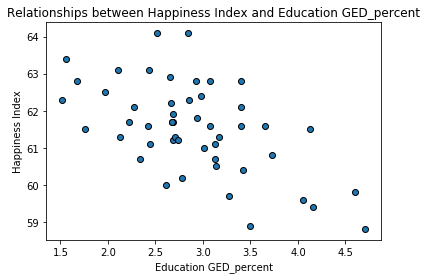

In [17]:
plt.scatter(census_education_hapiness["Education GED_percent"], census_education_hapiness["Happiness Rating"],marker="o", edgecolors="black")
plt.title("Relationships between Happiness Index and Education GED_percent")
plt.xlabel("Education GED_percent")
plt.ylabel("Happiness Index")

Text(0, 0.5, 'Happiness Index')

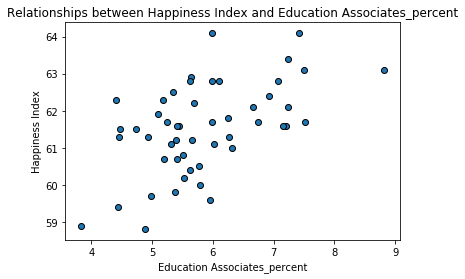

In [18]:
plt.scatter(census_education_hapiness["Education Associates_percent"], census_education_hapiness["Happiness Rating"],marker="o", edgecolors="black")
plt.title("Relationships between Happiness Index and Education Associates_percent")
plt.xlabel("Education Associates_percent")
plt.ylabel("Happiness Index")

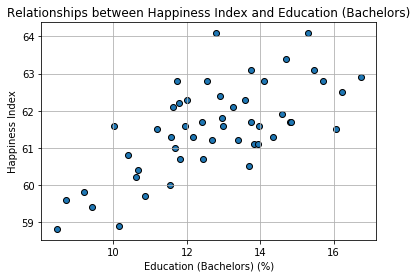

In [19]:
plt.scatter(census_education_hapiness["Education Bachelors_percent"], census_education_hapiness["Happiness Rating"],marker="o", edgecolors="black")
plt.title("Relationships between Happiness Index and Education (Bachelors)")
plt.xlabel("Education (Bachelors) (%)")
plt.ylabel("Happiness Index")
#Create the grid
plt.grid(True)
# Save the Figure
plt.savefig("images/RelationshipsHappinessEducationBachelors.png")

In [51]:
# States with greatest percent of Bachelors degrees
sorted_bachelors_census_education_hapiness = census_education_hapiness.sort_values("Education Bachelors_percent", ascending=False)
sorted_bachelors_census_education_hapiness.head()

,State,Name,Population,Median Age,Household Income,Per Capita Income,Education None,Education Bachelors,Unemployment Rate,Education None_percent,Education GED_percent,Education High School_percent,Education Associates_percent,Education Bachelors_percent,Education Masters_percent,Education Professional_percent,Education Doctorate_percent,Happiness Rating
5,08,Colorado,5436519.0,36.5,65458.0,34845.0,34489.0,909794.0,2.811652,0.634395,2.648128,11.914186,5.648431,16.734863,7.210386,1.530262,1.131091,62.9
19,25,Massachusetts,6789319.0,39.4,74167.0,39913.0,65956.0,1101605.0,3.311908,0.971467,1.973114,15.152065,5.351494,16.225560,9.093548,2.013751,1.843278,62.5
29,34,New Jersey,8960161.0,39.6,76475.0,39069.0,81641.0,1439971.0,3.662512,0.911156,1.760928,17.464139,4.468938,16.070816,7.354444,1.719601,1.058195,61.5
27,33,New Hampshire,1331848.0,42.7,71305.0,36914.0,5158.0,209224.0,2.520258,0.387281,2.931716,16.807098,7.064470,15.709300,7.350013,1.356987,1.003868,62.8
22,27,Minnesota,5490726.0,37.9,65699.0,34712.0,42738.0,849439.0,2.376917,0.778367,2.107281,14.991478,7.502032,15.470431,5.540196,1.445656,0.960474,63.1


In [47]:
# States with greatest percent of GED education
sorted_GED_census_education_hapiness = census_education_hapiness.sort_values("Education GED_percent", ascending=False)
sorted_GED_census_education_hapiness.head()

,State,Name,Population,Median Age,Household Income,Per Capita Income,Education None,Education Bachelors,Unemployment Rate,Education None_percent,Education GED_percent,Education High School_percent,Education Associates_percent,Education Bachelors_percent,Education Masters_percent,Education Professional_percent,Education Doctorate_percent,Happiness Rating
46,54,West Virginia,1836843.0,42.2,44061.0,24774.0,10439.0,155423.0,3.139027,0.568312,4.705900,23.859960,4.885665,8.461420,4.061153,0.887174,0.604570,58.8
16,21,Kentucky,4424376.0,38.6,46535.0,25888.0,32245.0,406916.0,3.180494,0.728803,4.604762,17.737846,5.380646,9.197139,4.640790,1.169634,0.645899,59.8
3,05,Arkansas,2977944.0,37.9,43813.0,24426.0,23003.0,280677.0,2.858617,0.772446,4.155988,18.728458,4.440010,9.425194,3.730560,0.878324,0.654848,59.4
41,47,Tennessee,6597381.0,38.6,48708.0,27277.0,49807.0,738613.0,3.194540,0.754951,4.121438,18.029230,4.735849,11.195549,4.563978,1.109440,0.816430,61.5
23,28,Mississippi,2986220.0,36.9,42009.0,22500.0,26200.0,259993.0,3.944318,0.877363,4.054021,15.842034,5.945175,8.706425,3.756388,0.878904,0.633075,59.6


In [48]:
# Add parks data
parks = pd.read_csv("./park_count.csv")
parks.head()

,Unnamed: 0,State,Parks,latitude,longitude,Name
0,0,AK,19,63.588753,-154.493062,Alaska
1,1,AL,7,32.318231,-86.902298,Alabama
2,2,AR,7,35.201050,-91.831833,Arkansas
3,3,AZ,21,34.048928,-111.093731,Arizona
4,4,CA,30,36.778261,-119.417932,California


In [51]:
# Merge happiness and parks data
parks_hapiness = pd.merge(parks, happiness, on="Name")
# sorted_parks_hapiness = parks_hapiness.sort_values(parks["Parks"], ascending=False)
parks_hapiness.head()

,Unnamed: 0,State,Parks,latitude,longitude,Name,Happiness Rating
0,0,AK,19,63.588753,-154.493062,Alaska,61.6
1,1,AL,7,32.318231,-86.902298,Alabama,60.8
2,2,AR,7,35.201050,-91.831833,Arkansas,59.4
3,3,AZ,21,34.048928,-111.093731,Arizona,62.2
4,4,CA,30,36.778261,-119.417932,California,62.3


In [16]:
#See if there is any correlation of happiness rating with number of parks
parks_hapiness.corr(method='pearson', min_periods=1)

,Unnamed: 0,Parks,latitude,longitude,Happiness Rating
Unnamed: 0,1.000000,-0.063774,0.126222,0.170230,0.049891
Parks,-0.063774,1.000000,-0.082613,-0.122584,0.101775
latitude,0.126222,-0.082613,1.000000,-0.088909,0.211606
longitude,0.170230,-0.122584,-0.088909,1.000000,-0.232386
Happiness Rating,0.049891,0.101775,0.211606,-0.232386,1.000000


In [34]:
# Add dance data
dance = pd.read_csv("./park_dance.csv")
dance.head()

,Unnamed: 0,State,Parks,latitude,longitude,Name,Dances
0,0,AK,19,63.588753,-154.493062,Alaska,3
1,1,AL,7,32.318231,-86.902298,Alabama,2
2,2,AR,7,35.201050,-91.831833,Arkansas,2
3,3,AZ,21,34.048928,-111.093731,Arizona,4
4,4,CA,30,36.778261,-119.417932,California,29


In [40]:
# Merge happiness and dance data
dance_hapiness = pd.merge(dance, happiness, on="Name")

dance_hapiness.head()

,Unnamed: 0,State,Parks,latitude,longitude,Name,Dances,Happiness Rating
0,0,AK,19,63.588753,-154.493062,Alaska,3,61.6
1,1,AL,7,32.318231,-86.902298,Alabama,2,60.8
2,2,AR,7,35.201050,-91.831833,Arkansas,2,59.4
3,3,AZ,21,34.048928,-111.093731,Arizona,4,62.2
4,4,CA,30,36.778261,-119.417932,California,29,62.3


In [20]:
#See if there is any correlation of happiness rating with number of dance groups in the states
dance_hapiness.corr(method='pearson', min_periods=1)

,Unnamed: 0,Parks,latitude,longitude,Dances,Happiness Rating
Unnamed: 0,1.000000,-0.034061,0.099995,0.222460,0.059267,-0.031273
Parks,-0.034061,1.000000,-0.052502,-0.143122,0.620473,0.164447
latitude,0.099995,-0.052502,1.000000,-0.064131,0.093209,0.122746
longitude,0.222460,-0.143122,-0.064131,1.000000,0.131221,-0.215831
Dances,0.059267,0.620473,0.093209,0.131221,1.000000,0.177770
Happiness Rating,-0.031273,0.164447,0.122746,-0.215831,0.177770,1.000000
